In [89]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

import datetime

In [90]:
colors = cm.tab10

In [91]:
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovery = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [92]:
confirmed.columns = list(confirmed.columns[:4]) + [datetime.datetime.strptime(c, '%m/%d/%y').strftime('%Y%m%d') for c in confirmed.columns[4:]]
deaths.columns = list(deaths.columns[:4]) + [datetime.datetime.strptime(c, '%m/%d/%y').strftime('%Y%m%d') for c in deaths.columns[4:]]
recovery.columns = list(recovery.columns[:4]) + [datetime.datetime.strptime(c, '%m/%d/%Y').strftime('%Y%m%d') for c in recovery.columns[4:]]

In [93]:
if all(pd.isnull(confirmed.iloc[:,-1])):
    confirmed = confirmed.iloc[:,:-1]
    deaths = deaths.iloc[:,:-1]
    recovery = recovery.iloc[:,:-1]
    
if recovery.shape[1] == (confirmed.shape[1] - 1):
    recovery[confirmed.columns[-1]] = recovery[confirmed.columns[-2]]

In [94]:
regions = ['Victoria', 'Germany', 'US', 'Italy', 'France']
#regions = ['Australia', 'New Zealand', 'Victoria']

In [95]:
death_rate = pd.DataFrame()
recovery_rate = pd.DataFrame()
active_cases = pd.DataFrame()
for region in regions:
    idxc = (confirmed['Province/State'] == region)
    idxd = (deaths['Province/State'] == region)
    idxr = (recovery['Province/State'] == region)
    if sum(idxc) == 0:
        idxc = (confirmed['Country/Region'] == region)
    if sum(idxd) == 0:
        idxd = (deaths['Country/Region'] == region)
    if sum(idxr) == 0:
        idxr = (recovery['Country/Region'] == region)
    total_cases = confirmed.loc[idxc].iloc[:,4:].sum(axis = 0)
    died = deaths.loc[idxd].iloc[:,4:].sum(axis = 0)
    recovered = recovery.loc[idxr].iloc[:,4:].sum(axis = 0)
    death_rate[region] = died / total_cases
    recovery_rate[region] = recovered / total_cases
    active_cases[region] = total_cases - recovered - died
    
death_rate = death_rate.fillna(0)
recovery_rate = recovery_rate.fillna(0)

## States

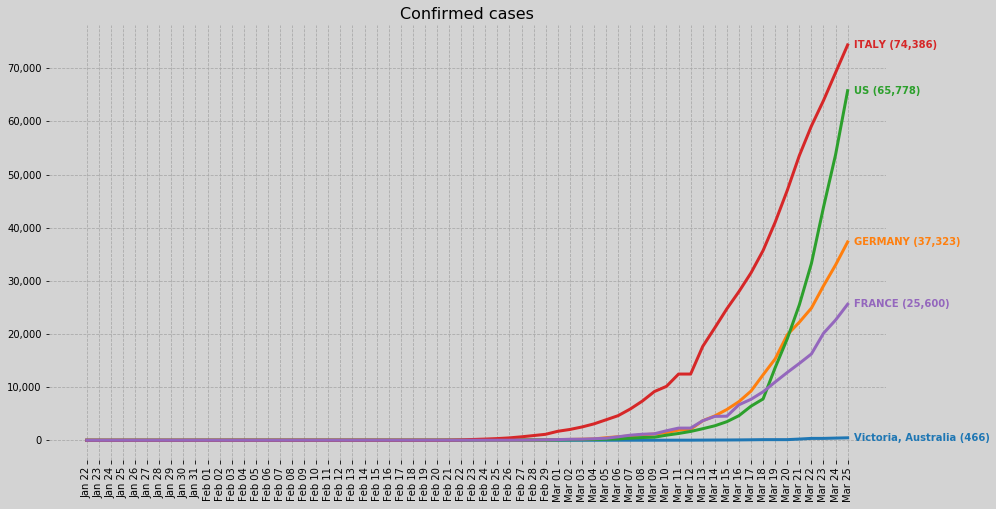

In [96]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

minx = 0

for n,s in enumerate(regions):
    region = regions[n]
    idx = (confirmed['Province/State'] == region)
    if sum(idx) == 0:
        idx = (confirmed['Country/Region'] == region)
        l = '{}'.format(confirmed.loc[idx, 'Country/Region'].head(1).item()).upper()
    else:
        l = '{}, {}'.format(region, confirmed.loc[idx, 'Country/Region'].head(1).item())
    dat = confirmed.loc[idx]
    dat = dat.iloc[:,4:].sum(axis = 0)
    
    y = list(dat)
    x = [datetime.datetime.strptime(c, '%Y%m%d') for c in dat.index]
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp > minx:
        minx = tmp
    
    ax.plot(x, y, color = colors(n), linewidth = 3)
    ax.text(x[-1]+datetime.timedelta(0.5), y[-1], '{} ({:,.0f})'.format(l, y[-1]), color = colors(n), va = 'center', ha = 'left', fontweight = 'bold')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks(x)
#ax.set_xlim((x[minx-5], x[-1]))
ax.set_title('Confirmed cases', fontsize = 16)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')
    
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

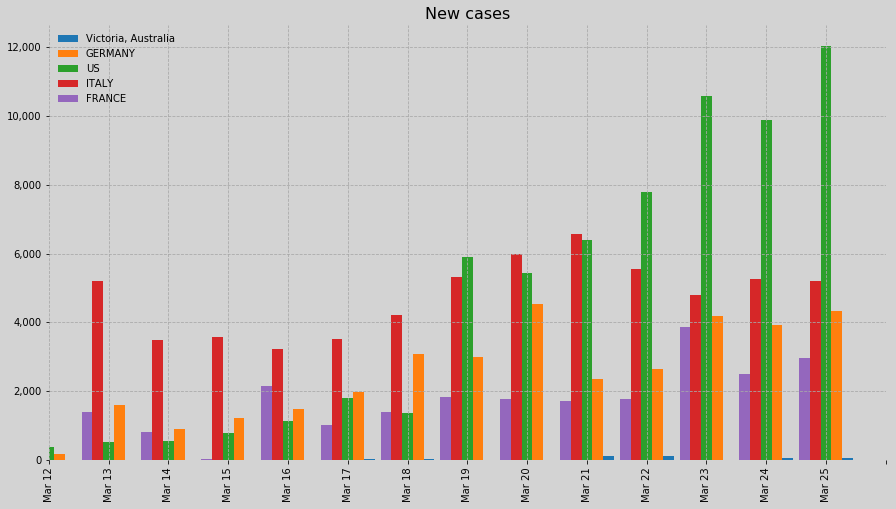

In [97]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

minx = 0
width = 0.9/len(regions)

for n,s in enumerate(regions):
    region = regions[n]
    idx = (confirmed['Province/State'] == region)
    if sum(idx) == 0:
        idx = (confirmed['Country/Region'] == region)
        l = '{}'.format(confirmed.loc[idx, 'Country/Region'].head(1).item()).upper()
    else:
        l = '{}, {}'.format(region, confirmed.loc[idx, 'Country/Region'].head(1).item())
    dat = confirmed.loc[idx]
    dat = dat.iloc[:,4:].sum(axis = 0)
    
    y = np.diff(list(dat))
    x = np.arange(len(y))
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp > minx:
        minx = tmp
    
    xpos = x + (len(regions)/2 * width) - (n*width) - (width/2)
    ax.bar(x = xpos, height = y, width = width, color = colors(n), label = l)

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')
ax.legend(frameon = False)
ax.set_title('New cases', fontsize = 16)

x = [datetime.datetime.strptime(c, '%Y%m%d') for c in dat.index][1:]
ax.set_xticks(np.arange(len(x)+10))
ax.set_xticklabels([c.strftime('%b %d') for c in x])
ax.set_xlim(max(minx-5,0), len(x))
ax.set_xlim(ax.get_xlim()[1]-14, ax.get_xlim()[1])

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
#ax.xaxis.set_major_formatter(xfmt)

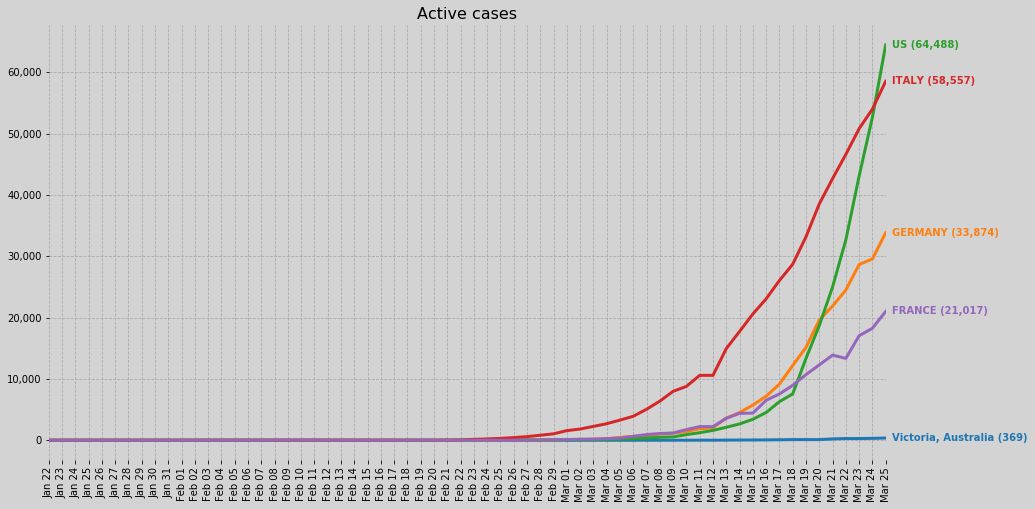

In [98]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

minx = len(active_cases)

for n,s in enumerate(active_cases.columns):
    region = regions[n]
    idx = (confirmed['Province/State'] == region)
    if sum(idx) == 0:
        idx = (confirmed['Country/Region'] == region)
        l = '{}'.format(confirmed.loc[idx, 'Country/Region'].head(1).item()).upper()
    else:
        l = '{}, {}'.format(region, confirmed.loc[idx, 'Country/Region'].head(1).item())
        
    y = active_cases[s]
    x = [datetime.datetime.strptime(c, '%Y%m%d') for c in active_cases.index]
    
    tmp = next((i for i, x in enumerate(y) if x), len(death_rate))
    if tmp < minx:
        minx = tmp
        
    ax.plot(x, y, color = colors(n), linewidth = 3)
    ax.text(x[-1:][0]+datetime.timedelta(0.5), y[-1], '{} ({:,.0f})'.format(l, y[-1]), color = colors(n), fontweight = 'bold', va = 'center', ha = 'left')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks(x)
ax.set_xlim((x[max(minx-5, 0)], x[-1]))
ax.set_title('Active cases', fontsize = 16)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')

ax.set_yticklabels(['{:,.0f}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

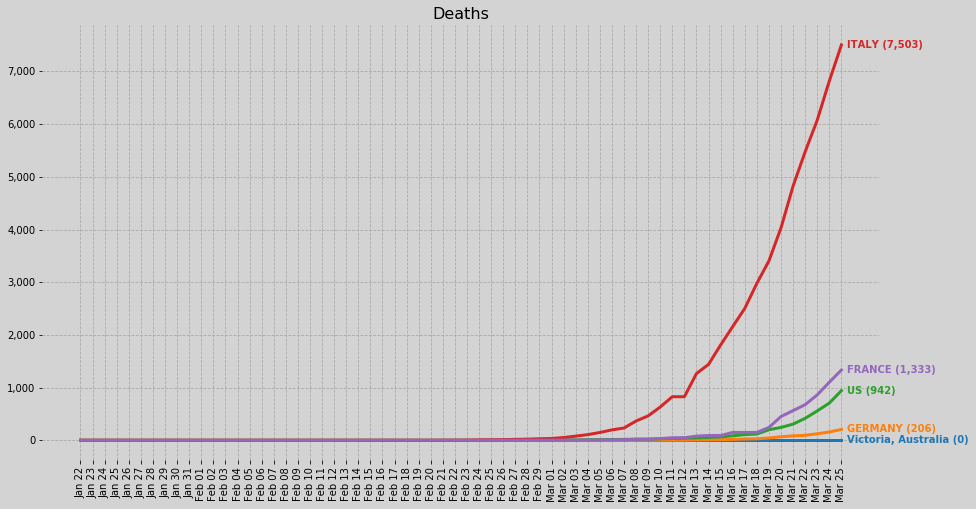

In [99]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

minx = 0

for n,s in enumerate(regions):
    region = regions[n]
    idx = (confirmed['Province/State'] == s)
    if sum(idx) == 0:
        idx = (confirmed['Country/Region'] == s)
        l = '{}'.format(confirmed.loc[idx, 'Country/Region'].head(1).item()).upper()
    else:
        l = '{}, {}'.format(region, confirmed.loc[idx, 'Country/Region'].head(1).item())
    dat = deaths.loc[idx]
    dat = dat.iloc[:,4:].sum(axis = 0).replace(to_replace=0, method='ffill')
    
    y = list(dat)
    x = [datetime.datetime.strptime(c, '%Y%m%d') for c in dat.index]
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp is None:
        minx = len(death_rate)
    elif tmp < minx:
        minx = tmp
    
    ax.plot(x, y, color = colors(n), linewidth = 3)
    ax.text(x[-1]+datetime.timedelta(0.5), y[-1], '{} ({:,.0f})'.format(l, y[-1]), color = colors(n), va = 'center', ha = 'left', fontweight = 'bold')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks(x)
#ax.set_xlim((x[minx-5], x[-1]))
ax.set_title('Deaths', fontsize = 16)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')
    
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

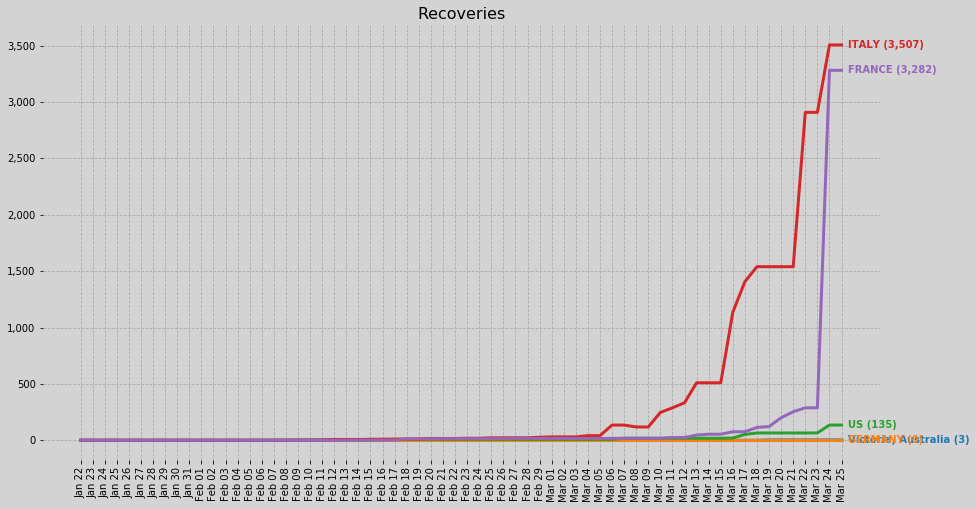

In [100]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

minx = 0

for n,s in enumerate(regions):
    region = regions[n]
    idx = (confirmed['Province/State'] == region)
    if sum(idx) == 0:
        idx = (confirmed['Country/Region'] == region)
        l = '{}'.format(confirmed.loc[idx, 'Country/Region'].head(1).item()).upper()
    else:
        l = '{}, {}'.format(region, confirmed.loc[idx, 'Country/Region'].head(1).item())
    dat = recovery.loc[idx]
    dat = dat.iloc[:,4:].sum(axis = 0).replace(to_replace=0, method='ffill')
    
    y = list(dat)
    x = [datetime.datetime.strptime(c, '%Y%m%d') for c in dat.index]
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp is None:
        minx = len(death_rate)
    elif tmp < minx:
        minx = tmp
    
    ax.plot(x, y, color = colors(n), linewidth = 3)
    ax.text(x[-1]+datetime.timedelta(0.5), y[-1], '{} ({:,.0f})'.format(l, y[-1]), color = colors(n), va = 'center', ha = 'left', fontweight = 'bold')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks(x)
#ax.set_xlim((x[minx-5], x[-1]))
ax.set_title('Recoveries', fontsize = 16)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')
    
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

## Rates

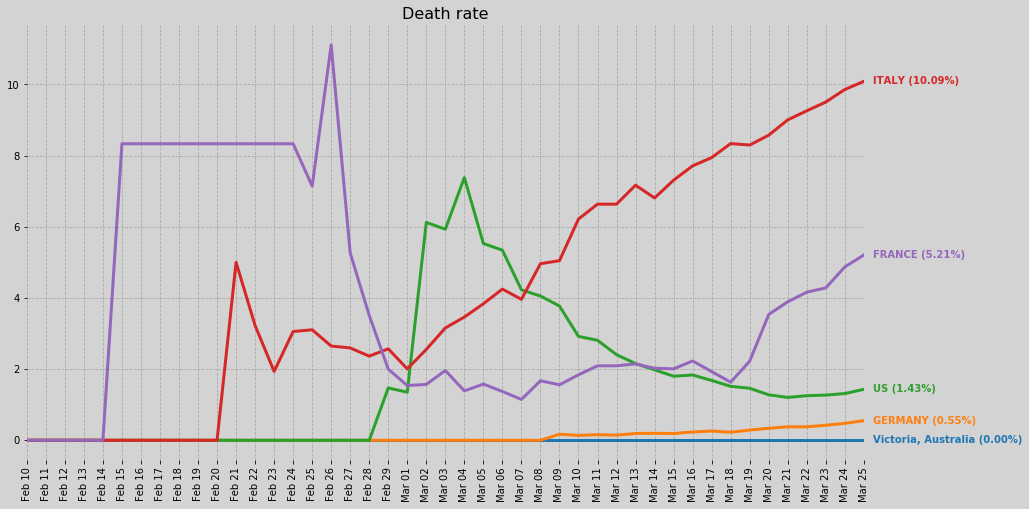

In [101]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

minx = len(death_rate)

for n,s in enumerate(death_rate.columns):
    
    region = regions[n]
    idx = (confirmed['Province/State'] == region)
    if sum(idx) == 0:
        idx = (confirmed['Country/Region'] == region)
        l = '{}'.format(confirmed.loc[idx, 'Country/Region'].head(1).item()).upper()
    else:
        l = '{}, {}'.format(region, confirmed.loc[idx, 'Country/Region'].head(1).item())
        
    y = death_rate[s]
    x = [datetime.datetime.strptime(c, '%Y%m%d') for c in death_rate.index]
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp is None:
        minx = len(death_rate)
    elif tmp < minx:
        minx = tmp
        
    ax.plot(x, y*100, color = colors(n), linewidth = 3)
    ax.text(x[-1:][0]+datetime.timedelta(0.5), y[-1]*100, '{} ({:.2f}%)'.format(l, y[-1]*100), color = colors(n), fontweight = 'bold', va = 'center', ha = 'left')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

x = [datetime.datetime.strptime(c, '%Y%m%d') for c in death_rate.index]
ax.set_xticks(x)
ax.set_xlim((x[max(minx-5, 0)], x[-1]))
ax.set_title('Death rate', fontsize = 16)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

In [ ]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

minx = len(recovery_rate)

for n,s in enumerate(recovery_rate.columns):
    
    region = regions[n]
    idx = (confirmed['Province/State'] == region)
    if sum(idx) == 0:
        idx = (confirmed['Country/Region'] == region)
        l = '{}'.format(confirmed.loc[idx, 'Country/Region'].head(1).item()).upper()
    else:
        l = '{}, {}'.format(region, confirmed.loc[idx, 'Country/Region'].head(1).item())
    y = recovery_rate[s]
    x = [datetime.datetime.strptime(c, '%Y%m%d') for c in recovery_rate.index]
    
    tmp = next((i for i, x in enumerate(y) if x), None)
    if tmp is None:
        minx = len(death_rate)
    elif tmp < minx:
        minx = tmp
        
    ax.plot(x, y*100, color = colors(n), linewidth = 3)
    ax.text(x[-1:][0]+datetime.timedelta(0.5), y[-1]*100, '{} ({:.2f}%)'.format(l, y[-1]*100), color = colors(n), fontweight = 'bold', va = 'center', ha = 'left')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks(x)
#ax.set_xlim((x[max(minx-5, 0)], x[-1]))
ax.set_title('Recovery rate', fontsize = 16)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_ha('center')
    tick.set_va('top')

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

xfmt = mdates.DateFormatter('%b %d')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)